In [1]:
%matplotlib inline

import h5py, pandas, cPickle, random, sys
import numpy as np

from molecules.utils import one_hot_array, one_hot_index, from_one_hot_array, \
    decode_smiles_from_indexes, load_dataset

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, LSTM, Dropout, Input, Flatten, Reshape, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils

from keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython import display

Using TensorFlow backend.


In [2]:
data = h5py.File('data/prep_500k.h5', 'r')
data_train = np.array(data['data_train'])
data_test = np.array(data['data_test'])
charset = data['charset']

In [3]:
def plot_loss(losses):
    display.clear_output(wait = True)
    display.display(plt.gcf())
    plt.figure(figsize=(10,8))
    plt.plot(losses["d"], label='Discriminative loss')
    plt.plot(losses["g"], label='Generative loss')
    plt.legend()
    plt.show()

def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [17]:
g_input = Input(shape = [100])
H = RepeatVector(120, input_shape=(100,))(g_input)
H = LSTM(256, return_sequences = True)(H)
H = LSTM(256, return_sequences = True)(H)
H = LSTM(120, return_sequences = True)(H)
H = Dropout(0.2)(H)
g_V = TimeDistributed(Dense(charset.shape[0], activation='softmax'))(H)

generator = Model(g_input, g_V)
generator.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy'
)
# print(generator.summary())

d_input = Input(shape = [120, charset.shape[0]])
H = LSTM(64, return_sequences=True)(d_input)
H = LSTM(64)(d_input)
H = Dropout(0.6)(H)
d_V = Dense(2, activation = 'softmax')(H)

discriminator = Model(d_input, d_V)
discriminator.compile(
    optimizer = 'sgd',
    loss = 'categorical_crossentropy'
)
# print(discriminator.summary())

make_trainable(discriminator, False)

gan_input = Input(shape = [100])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy'
)
GAN.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 100)           0                                            
____________________________________________________________________________________________________
model_8 (Model)                  (None, 120, 55)       1078495     input_11[0][0]                   
____________________________________________________________________________________________________
model_9 (Model)                  (None, 2)             30850       model_8[1][0]                    
Total params: 1,109,345
Trainable params: 1,078,495
Non-trainable params: 30,850
____________________________________________________________________________________________________


In [ ]:
# Pre-train the discriminator network ...

# n_pretrain = 10000
# smiles_batch = data_train[np.random.choice(data_train.shape[0], size = n_pretrain)]
# noise_gen = np.random.uniform(0, 1, size=[n_pretrain, 100])
# generated = generator.predict(noise_gen)

# X = np.concatenate((smiles_batch, generated))
# y = np.zeros([2 * n_pretrain, 2])
# y[:n_pretrain, 1] = 1
# y[n_pretrain:, 0] = 1

# make_trainable(discriminator, True)
# discriminator.fit(X, y, nb_epoch = 1, batch_size = 512)
# y_hat = discriminator.predict(X, verbose = 1)

# y_hat_idx = np.argmax(y_hat, axis = 1)
# y_idx = np.argmax(y, axis = 1)
# diff = y_idx - y_hat_idx
# n_tot = y.shape[0]
# n_rig = (diff == 0).sum()
# acc = n_rig * 100.0 / n_tot
# print("Accuracy: %0.02f percent (%d of %d) right" % (acc, n_rig, n_tot))

In [18]:
losses = {"d":[], "g":[]}

def pretrain(n_pretrain = 1e6, nb_epoch = 20, batch_size = 512):
    make_trainable(discriminator, False)
    smiles_batch = data_train[np.random.choice(data_train.shape[0], size = n_pretrain)]
    noise_gen = np.random.normal(0, 1, size=[n_pretrain, 100])
    generator.fit(
        noise_gen,
        smiles_batch,
        nb_epoch = nb_epoch,
        batch_size = batch_size,
        callbacks = [
            ReduceLROnPlateau(monitor = 'loss',
                              factor = 0.2,
                              patience = 3,
                              min_lr = 0.0001)])

def train_for_epochs(nb_epoch = 5000, plt_frq = 25, BATCH_SIZE = 32):
    for e in tqdm(range(nb_epoch)):
        # Generate smiles
        smiles_batch = data_train[np.random.choice(data_train.shape[0] - 1, size = BATCH_SIZE)]
        noise_gen = np.random.normal(0, 1, size=[BATCH_SIZE, 100])
        generated = generator.predict(noise_gen)

        # Train discriminator
        X = np.concatenate((smiles_batch, generated))
        y = np.zeros([2*BATCH_SIZE, 2])
        if np.random.normal(0, 1) < 0.9:
            y[0:BATCH_SIZE, 1] = np.random.normal(0.9, 0.1)
            y[BATCH_SIZE:, 0] = np.random.normal(0.2, 0.1)
        else:
            y[0:BATCH_SIZE, 0] = np.random.normal(0.9, 0.1)
            y[BATCH_SIZE:, 1] = np.random.normal(0.2, 0.1)

        make_trainable(discriminator, True)
        d_loss = discriminator.train_on_batch(X, y)
        losses["d"].append(d_loss)

        # Train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0, 1, size = [BATCH_SIZE, 100])
        y2 = np.zeros([BATCH_SIZE, 2])
        y2[:,1] = np.random.normal(0.9, 0.1)

        make_trainable(discriminator, False)
        g_loss = GAN.train_on_batch(noise_tr, y2)
        losses["g"].append(g_loss)

        # Updates plots
        if e % plt_frq == plt_frq - 1:
            plot_loss(losses)

In [19]:
pretrain(n_pretrain=1e5, nb_epoch=5)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Epoch 1/5
100000/100000 [==============================] - 135s - loss: 1.5646   
Epoch 2/5
100000/100000 [==============================] - 132s - loss: 1.3174   
Epoch 3/5
100000/100000 [==============================] - 130s - loss: 1.2949   
Epoch 4/5
100000/100000 [==============================] - 130s - loss: 1.2801   
Epoch 5/5
100000/100000 [==============================] - 131s - loss: 1.2704   


In [21]:
generated = generator.predict(np.random.normal(0, 1, size=[10, 100])).argmax(axis=2)
for g in generated:
    print(decode_smiles_from_indexes(g, charset))

CC1ccccccccccccccccccccccccccccccc
CCCCcccccccccccccccccccccccccccc
CCCCccccccccccccccccccccccccccc
CC1Ccccccccccccccccccccccccccccccc
CCCCcccccccccccccccccccccccccccccc
CC1cccccccccccccccccccccccccccccccc
CC1Cccccccccccccccccccccccccccccccccc
CCCCccccccccccccccccccccccccccccccccccccccc
CCCCcccccccccccccccccccccccccccccc
CCCcccccccccccccccccccccccccccccccccc


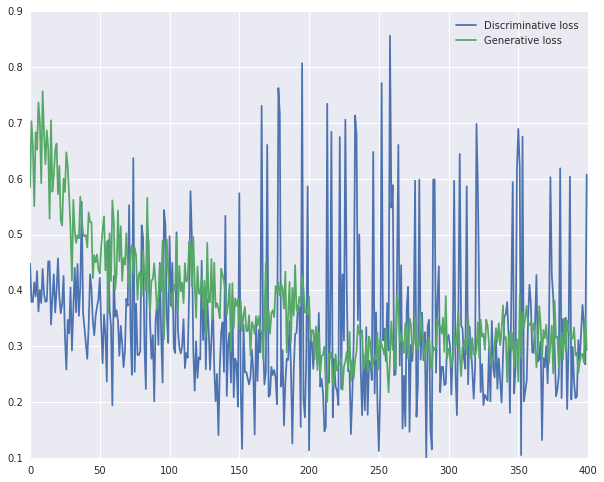

100%|██████████| 400/400 [22:15<00:00,  3.47s/it]


In [23]:
train_for_epochs(nb_epoch = 400, plt_frq = 20, BATCH_SIZE = 512)

In [24]:
generated = generator.predict(np.random.normal(0, 1, size=[10, 100])).argmax(axis=2)
for g in generated:
    print(decode_smiles_from_indexes(g, charset))

CCcccC
CCcccN
CCcccc\
CCcccC
CCcCc
CCCcccccc\
CCcccC
CCcCN
CCcccc
CCccc
